In [17]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [48]:
def lomb_scargle(amp, 
                 time, 
                 oversample,
                 f_max = 100.):
    
    """Computes the lomb-scargle periodigram for a set of time and amplitude data
    INPUT:  amp        = amplitude data of the signal of interest
            time       = time points at which amp was obtained
            oversample = the factor to oversample past the nyquist frequency
            f_max      = the maximum frequncy to consider fitting to
    OUTPUT: freq       = the frequency grid used
            ps         = the power spectrum at points specified in freq""" 
    
    #Need to normalize the input data
    mean = np.mean(amp)
    amp = amp - mean
    duration = np.amax(time) - np.amin(time)
    
    #Determine the frequency grid
    f_min = 1. / duration                          #Minimum frequency is equivalent to the period of the whole system
    num_f = int(oversample * duration * f_max)     #Oversampling the nyquist frequency
    freq = np.linspace(f_min, f_max, num_f)
    
    #Calculate the value of tau at all frequencies
    tau = np.zeros_like(freq)
    omega = 2 * np.pi * freq                       #Calculate quantities separately for ease of readibility, redundancy
    for i, val in enumerate(omega):
        s_tau = np.sum( np.sin(2 * val * time) )
        c_tau = np.sum( np.cos(2 * val * time) )
        tau[i] = (1. / (2 * val)) * np.arctan( s_tau / c_tau )
    
    #Calculate the power spectrum at each frequency
    ps = np.zeros_like(freq)
    for i, f in enumerate(freq):
        om = 2 * np.pi * f
        c  = np.cos( om * ( time - tau[i] ) )      #Calculate each term of the power equation separately
        s  = np.sin( om * ( time - tau[i] ) )
        sc = np.sum(amp * c)**2
        ss = np.sum(amp * s)**2
        c2 = np.sum( c**2 )
        s2 = np.sum( s**2 )
        
        ps[i] = 0.5 * (  sc / c2 + ss / s2 )    
    
    return freq, ps
    

(0, 30)

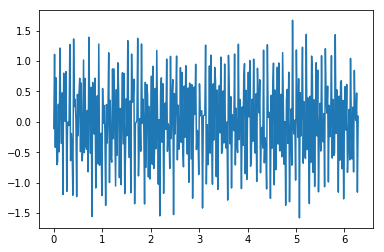

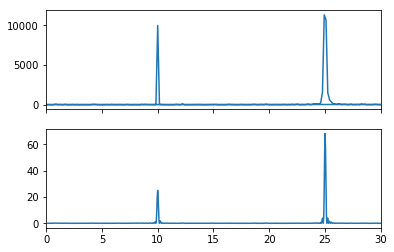

In [49]:
#Testing the function using both FFT and lomb-scargle for a simple example

t = np.linspace(0, 2*np.pi, 400)
v = 0.5 * np.sin(2 * np.pi * 10 * t) + 0.8 * np.sin(2 * np.pi * 25 * t) + 0.2 * np.random.normal(size=400)

v_fft = np.abs(np.fft.fft(v))
f_fft = np.fft.fftfreq(len(t), t[1] - t[0])

f_ls, v_ls = lomb_scargle(v, t, 4, f_max=30.)

plt.figure(0)
plt.plot(t, v)

plt.figure(1)
g, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(f_fft, v_fft**2)
ax[1].plot(f_ls, v_ls)
ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)

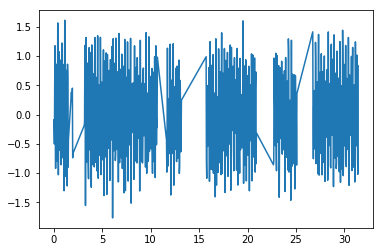

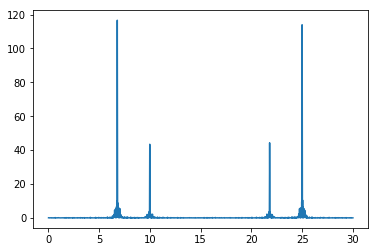

In [54]:
#Now to test the data when it is sampled with gaps

t = list(np.linspace(0, 10*np.pi, 1000))

#put together a new data set with gaps
t = t[0:49] + t[58:64] + t[100:341] + t[370:420] + t[500:666] + t[721:799] + t[850:]
t = np.asarray(t)
v = 0.5 * np.sin(2 * np.pi * 10 * t) + 0.8 * np.sin(2 * np.pi * 25 * t) + 0.2 * np.random.normal(size=t.size)

plt.figure(0)
plt.plot(t, v)

f_ls, v_ls = lomb_scargle(v, t, 4, f_max=30.)

plt.figure(2)
plt.plot(f_ls, v_ls)

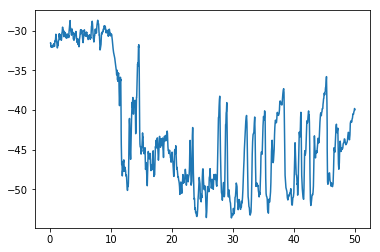

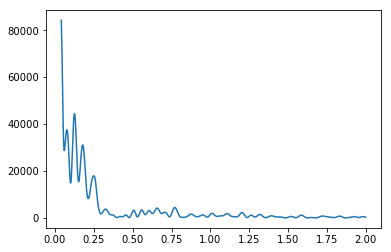

In [57]:
#Attempting to use a paleoclimate data set
#Data set of glacier surface temperature from GISP2 ice core
#Accessed at: ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/greenland/summit/gisp2/isotopes/gisp2_temp_accum_alley2000.txt

c_data = open("climate.txt","r")

time = []
temp = []
for i in range(1632):
    line = c_data.readline()
    line = line[:-1]
    time.append(float(line[:16].replace(" ","")))
    temp.append(float(line[16:].replace(" ","")))

plt.figure(0)
plt.plot(time, temp)

time = np.asarray(time)
temp = np.asarray(temp)

f_ls, v_ls = lomb_scargle(time, temp, 16, f_max=2.)
plt.figure(1)
plt.plot(f_ls, v_ls)

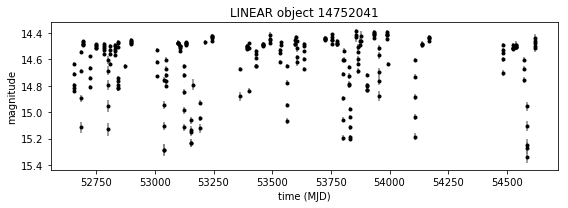

In [16]:
data = pd.read_csv('LINEAR_14752041.csv')


fig, ax = plt.subplots(figsize=(8, 3))
ax.errorbar(data.t, data.mag, data.magerr,
            fmt='.k', ecolor='gray', capsize=0)
ax.set(xlabel='time (MJD)',
       ylabel='magnitude',
       title='LINEAR object 14752041')
ax.invert_yaxis()

plt.tight_layout()
fig.savefig('fig01_LINEAR_data.png');